In [ ]:
import time
from textwrap import wrap

import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
from tensorflow.keras import Input
from tensorflow.keras.layers import (
    GRU,
    Add,
    AdditiveAttention,
    Attention,
    Concatenate,
    Dense,
    Embedding,
    LayerNormalization,
    Reshape,
    StringLookup,
    TextVectorization,
)
from tensorflow.keras import mixed_precision
from tensorflow.keras.optimizers import AdamW
print(tf.version.VERSION)

2.18.0


In [ ]:
#cHANGE THESE TO CONTROL THE ACCURACY/SPEED
VOCAB_SIZE=2000   #USE FEWER WORDS TO SPEED UP CONVERGENCE
ATTENTION_DIM=512    #SIZE OF DENSE LAYER IN ATTENTION
WORD_EMBEDDING_DIM=128

#INCEPTION_RESNET_V2 TAKES (299,299,3) IMAGE AS INPUTS AND RETURN FEATURES IN (8,8,1536) SHAPE
FEATURE_EXTRACTOR=tf.keras.applications.inception_resnet_v2.InceptionResNetV2(
    include_top=False, weights="imagenet"
)
IMG_HEIGHT=299
IMG_WEIGHT=299
IMG_CHANNELS=3
FEATURES_SHAPE=(8,8,1536)

In [ ]:
!pip install gcsfs
import gcsfs

In [ ]:
GCS_DIR="gs://asl-public/data/tensorflow_datasets/"
BUFFER_SIZE=1000

def get_image_label(example):
  caption=example["captions"]["text"][0]
  img=example["image"]
  img=tf.image.resize(img,(IMG_HEIGHT,IMG_WEIGHT))
  img=img/255
  return {"image_tensor": img,"caption":caption}

trainds=tfds.load("coco_captions",split="train",data_dir=GCS_DIR)

trainds=trainds.map(
    get_image_label,num_parallel_calls=tf.data.AUTOTUNE
).shuffle(BUFFER_SIZE)
trainds=trainds.prefetch(buffer_size=tf.data.AUTOTUNE)

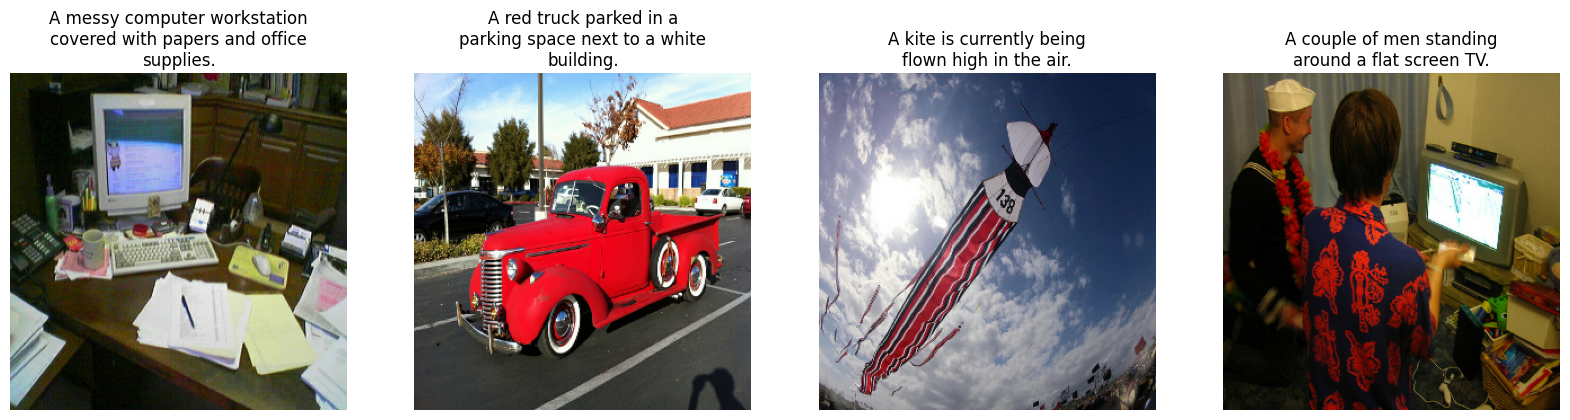

In [ ]:
f,ax=plt.subplots(1,4,figsize=(20,5))
for idx,data in enumerate(trainds.take(4)):
  ax[idx].imshow(data["image_tensor"].numpy())
  caption="\n".join(wrap(data["caption"].numpy().decode("utf-8"),30))
  ax[idx].set_title(caption)
  ax[idx].axis("off")

In [ ]:
def add_start_end_token(data):
  start=tf.convert_to_tensor("<start>")   #denotes starting of caption
  end=tf.convert_to_tensor("<end>")      #denotes ending of caption as caption is of variable length
  data["caption"]=tf.strings.join([start,data["caption"],end],separator=" ")  #joins the caption together using start and end tokens and caption btw them
  return data
trainds=trainds.map(add_start_end_token)

In [ ]:
MAX_CAPTION_LEN=64
#lowercase captions and remove special characters
def standardize(inputs):
  inputs=tf.strings.lower(inputs)
  return tf.strings.regex_replace(
      inputs,r"[!\"#$%&\(\)\*\+.,-/:;=?@\[\\\]^_`{|}~]?",""
  )
#tokenize all captions my mapping each word to a index in vocabulary
tokenizer=TextVectorization(
    max_tokens=VOCAB_SIZE,
    standardize=standardize,
    output_sequence_length=MAX_CAPTION_LEN,
  )
tokenizer.adapt(trainds.map(lambda x:x["caption"]))

In [ ]:
tokenizer(["<start> This is a sentence <end>"])

<tf.Tensor: shape=(1, 64), dtype=int64, numpy=
array([[  3, 165,  11,   2,   1,   4,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]])>

In [ ]:
sample_captions=[]
for d in trainds.take(5):
  sample_captions.append(d["caption"].numpy())

In [ ]:
sample_captions

[b'<start> A baseball player captured swinging at a game. <end>',
 b'<start> To bananas sitting on two blue plastic bowls. <end>',
 b'<start> A herd of animals standing on top of a grass covered hillside. <end>',
 b'<start> A woman tending to a baby in a suitcase. <end>',
 b'<start> An airplane wing as seen from inside the aircraft. <end>']

In [ ]:
print(tokenizer(sample_captions))

tf.Tensor(
[[   3    2   49   93    1  275   21    2   92    4    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]
 [   3   13  218   14    6   17   58  455  560    4    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]
 [   3    2  198    5  286   15    6   23    5    2   62   84  533    4
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0   

In [ ]:
for wordid in tokenizer([sample_captions[0]])[0]:
  print(tokenizer.get_vocabulary()[wordid],end=" ")

<start> a baseball player [UNK] swinging at a game <end>                                                       

In [ ]:
#converter from word to token
word_to_index=StringLookup(
    mask_token="",vocabulary=tokenizer.get_vocabulary()
)
#converter from token to word
index_to_word=StringLookup(
    mask_token="",vocabulary=tokenizer.get_vocabulary(),invert=True
)

In [ ]:
BATCH_SIZE=32
def create_ds_fn(data):
  img_tensor=data["image_tensor"] #EXTRACTS IMAGE DATA
  caption=tokenizer(data["caption"])  #TOKENIZES CAPTION USING TOKENIZER

  target=tf.roll(caption,-1,0) #SHIFTS CAPTION TOKENS ONE POSITION TO LEFT, EACH TOKEN PREDICTS NEXT TOKEN IN CAPITON IN TARGET SEQUENCE
  zeros=tf.zeros([1],dtype=tf.int64) #0 IS ADDED TO TARGET SEQUENCE TO MARK END OF CAPTION
  target=tf.concat((target[:-1],zeros),axis=-1)
  return (img_tensor,caption),target

batched_ds=( #DATASET IS TRANSFORMED INTO BATCHES SUITABLE FOR TRAINING
    trainds.map(create_ds_fn)
    .batch(BATCH_SIZE,drop_remainder=True) #GROUPS DATA INTO BATCH OF 32 AND DISCARD INCOMPLETE BATCHS AT END
    .prefetch(buffer_size=tf.data.AUTOTUNE) #PREFETCHES NEXT BATCH IS WHILE CURRENT BATCH IS UNDER PROCESS
)

In [ ]:
for (ing,caption), label in batched_ds.take(2):
  print(f"Image Shape: {ing.shape}")
  print(f"Caption Shape: {caption.shape}")
  print(f"Label Shape: {label.shape}")
  print(caption[0])
  print(label[0])


Image Shape: (32, 299, 299, 3)
Caption Shape: (32, 64)
Label Shape: (32, 64)
tf.Tensor(
[  3   2  12  26   2 546   1   5 232 286   4   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0], shape=(64,), dtype=int64)
tf.Tensor(
[  2  12  26   2 546   1   5 232 286   4   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0], shape=(64,), dtype=int64)
Image Shape: (32, 299, 299, 3)
Caption Shape: (32, 64)
Label Shape: (32, 64)
tf.Tensor(
[   3    2 1859  214  274    2  151   61    6    2 1290  571    4    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    

In [ ]:
FEATURE_EXTRACTOR.trainable=False
image_input=Input(shape=(IMG_HEIGHT,IMG_WEIGHT,IMG_CHANNELS)) #Extracts features from convolutional layer which gives us a vector of (BATCHSIZE,8,8,1536)
image_features=FEATURE_EXTRACTOR(image_input)
x=Reshape((FEATURES_SHAPE[0]*FEATURES_SHAPE[1],FEATURES_SHAPE[2]))(
    image_features #reshape vector to (BatchSize,63,1536)
)
encoder_output=Dense(ATTENTION_DIM, activation="relu")(x) #squash vector to len of attention_dim with a dense layer and return (batch_size,64,attention_dim)


In [ ]:
encoder=tf.keras.Model(inputs=image_input,outputs=encoder_output)
tf.keras.utils.plot_model(encoder,show_shapes=True)
encoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 299, 299, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ inception_resnet_v2 (Functional)     │ (None, 8, 8, 1536)          │      54,336,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 64, 1536)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64, 512)             │         786,944 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 55,123,680 (210.28 MB)

 Trainable params: 786,944 (3.00 MB)

 Non-trainable params: 54,336,736 (207.28 MB)

In [ ]:
word_input=Input(shape=(MAX_CAPTION_LEN,),name="words")
embed_x=Embedding(VOCAB_SIZE,ATTENTION_DIM)(word_input)

decoder_gru=GRU(
    ATTENTION_DIM,
    return_sequences=True,
    return_state=True
)
gru_output,gru_state=decoder_gru(embed_x)

decoder_attention = Attention()
context_vector=decoder_attention([gru_output,encoder_output])

addition=Add()([gru_output,context_vector])

layer_norm=LayerNormalization(axis=-1)
layer_norm_out=layer_norm(addition)

decoder_output_dense=Dense(VOCAB_SIZE)
decoder_output=decoder_output_dense(layer_norm_out)

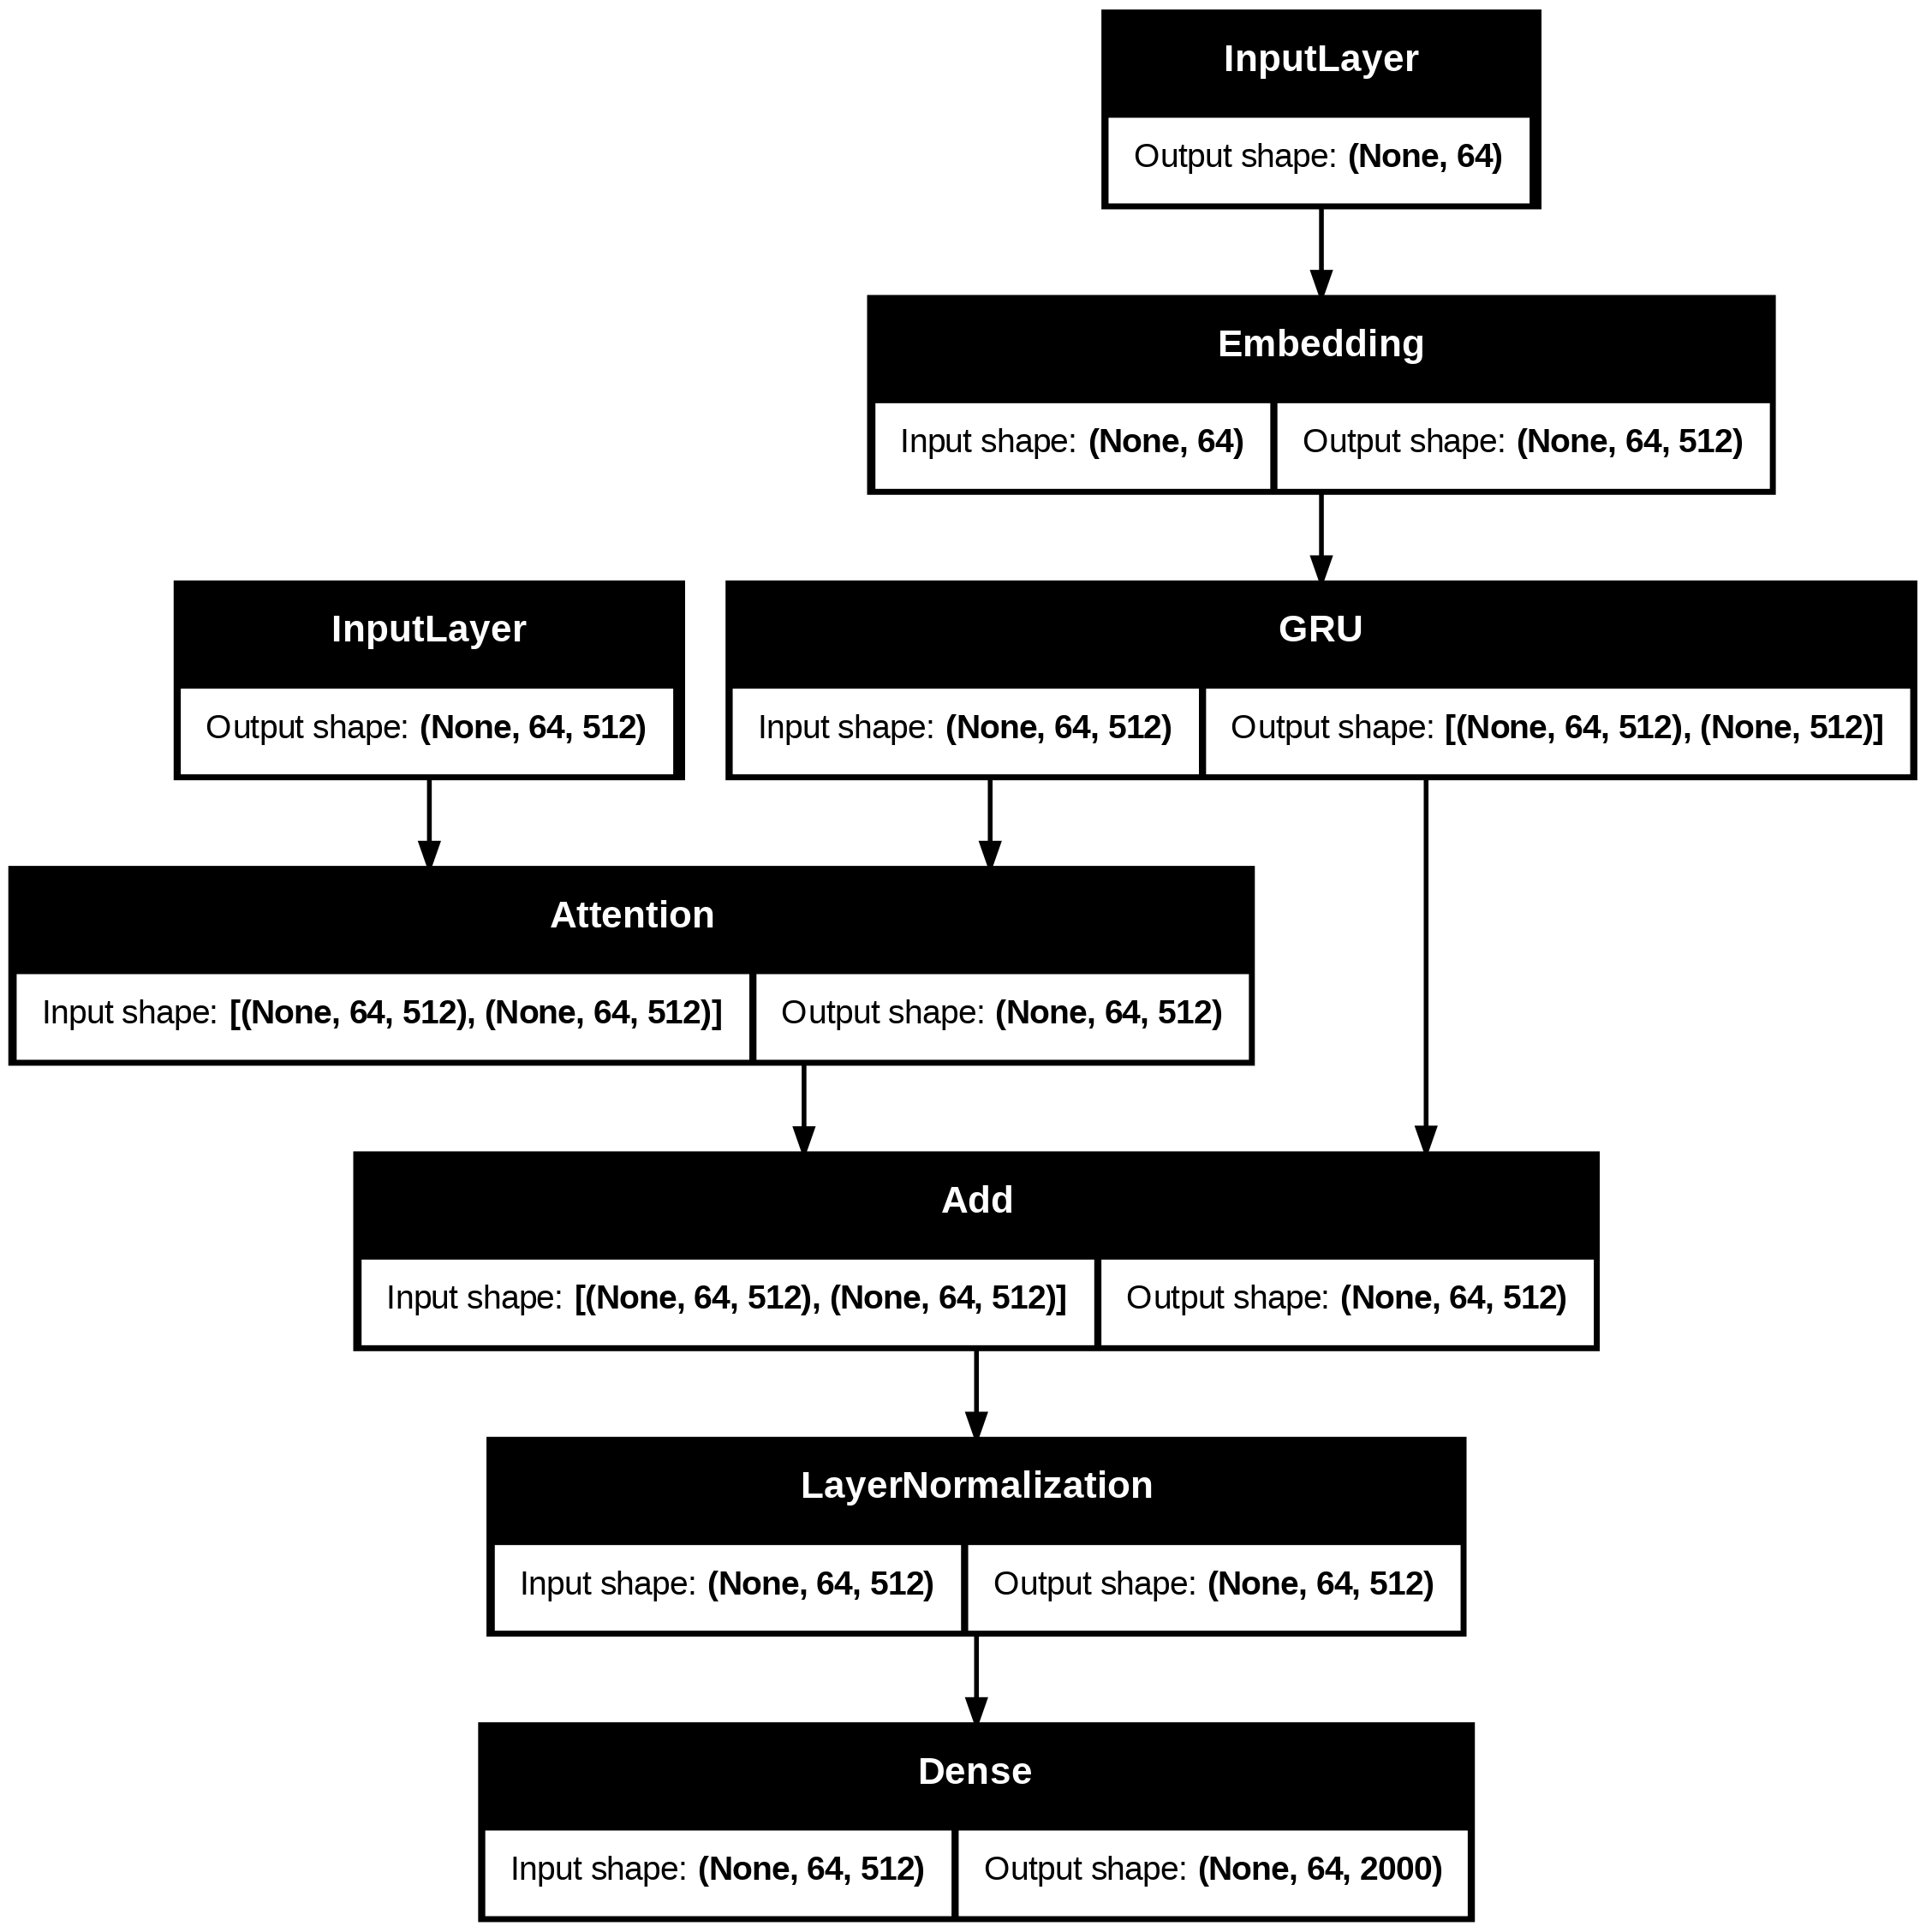

In [ ]:
decoder = tf.keras.Model(
    inputs=[word_input,encoder_output],outputs=decoder_output
)
tf.keras.utils.plot_model(decoder,show_shapes=True)

In [ ]:
decoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ words (InputLayer)        │ (None, 64)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 64, 512)        │      1,024,000 │ words[1][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru (GRU)                 │ [(None, 64, 512),      │      1,575,936 │ embedding[1][0]        │
│                           │ (None, 512)]           │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ keras_tensor_1561CLONE    │ (None, 64, 512)        │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention (Attention)     │ (None, 64, 512)        │              0 │ gru[1][0],             │
│                           │                        │                │ keras_tensor_1561CLON… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 64, 512)        │              0 │ gru[1][0],             │
│                           │                        │                │ attention[1][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 64, 512)        │          1,024 │ add[1][0]              │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 64, 2000)       │      1,026,000 │ layer_normalization[1… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 3,626,960 (13.84 MB)

 Trainable params: 3,626,960 (13.84 MB)

 Non-trainable params: 0 (0.00 B)

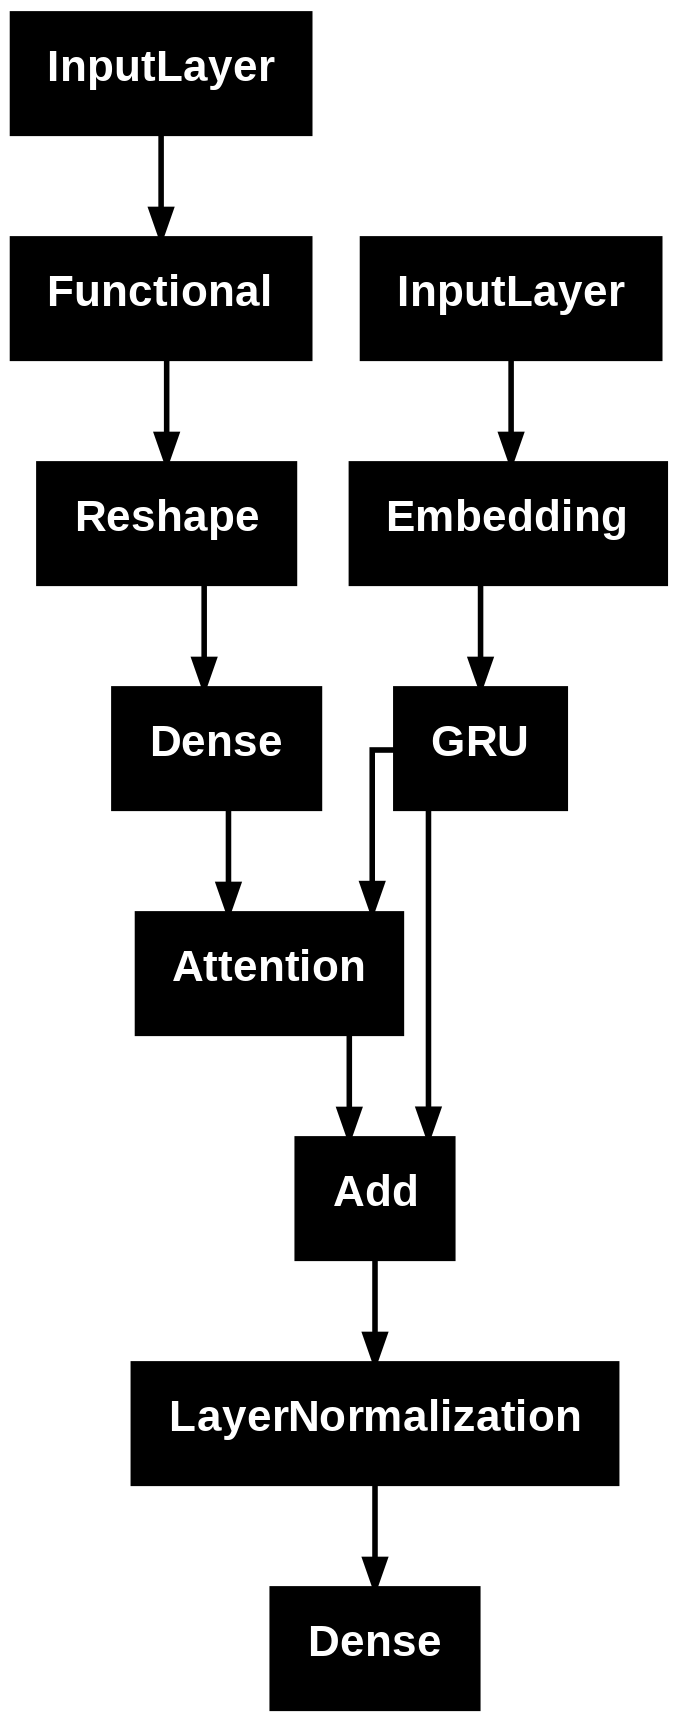

In [ ]:
image_caption_train_model=tf.keras.Model(
    inputs=[image_input,word_input],outputs=decoder_output
)
tf.keras.utils.plot_model(image_caption_train_model)

In [ ]:
loss_object=tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,reduction="none"
)
def loss_function(real,prod):
  loss_=loss_object(real,prod)
  mask=tf.math.logical_not(tf.math.equal(real,0))
  mask=tf.cast(mask,dtype=tf.int32)
  sentence_len=tf.shape(mask)[1] # This line was the potential problem
  indices=tf.range(sentence_len)
  loss_=tf.gather(loss_,indices,axis=1,batch_dims=1)
  return tf.reduce_mean(loss_,1)

In [ ]:
#policy=mixed_precision.Policy("mixed_float16")
#mixed_precision.set_global_policy(policy)

In [ ]:
optimizer=AdamW()
image_caption_train_model.compile(
    optimizer=optimizer,
    loss=loss_function
)

In [ ]:
history=image_caption_train_model.fit(batched_ds,epochs=1)

OperatorNotAllowedInGraphError: Exception encountered when calling GRU.call().

[1mIterating over a symbolic `tf.Tensor` is not allowed. You can attempt the following resolutions to the problem: If you are running in Graph mode, use Eager execution mode or decorate this function with @tf.function. If you are using AutoGraph, you can try decorating this function with @tf.function. If that does not work, then you may be using an unsupported feature or your source code may not be visible to AutoGraph. See https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/autograph/g3doc/reference/limitations.md#access-to-source-code for more information.[0m

Arguments received by GRU.call():
  • sequences=tf.Tensor(shape=(32, None, 512), dtype=float32)
  • initial_state=None
  • mask=None
  • training=True

In [ ]:
gru_state_input=Input(shape=(ATTENTION_DIM),name="gru_state_input")
gru_output,gru_state=decoder_gru(embed_x,initial_state=gru_state_input)

context_vector=decoder_attention([gru_output,encoder_output])
addition_output=Add()([gru_output,context_vector])
layer_norm_output=layer_norm(addition_output)

decoder_output=decoder_output_dense(layer_norm_output)

decoder_pred_model=tf.keras.Model(
    inputs=[word_input,gru_state_input,encoder_output],
    outputs=[decoder_output,gru_state]
)

In [ ]:
MINIMUM_SENTENCE_LENGTH=5

def predict_caption(filename):
  gru_state=tf.zeros((1,ATTENTION_DIM))
  img=tf.image.decode_jpeg(tf.io.read_file(filename),channels=IMG_CHANNELS)
  img=img/255

  features=encoder(tf.expand_dims(img,axis=0))
  dec_input=tf.expand_dims([word_to_index("<start>")],0)
  result=[]
  for i in range(MAX_CAPTION_LEN):
    predictions,gru_state=decoder_pred_model(
        [dec_input,gru_state,features]
    )
    top_probs,top_idxs=tf.math.top_k(
        input=predictions[0][0],k=10,sorted=False
    )
    chosen_id=tf.random.categorical([top_probs],1)[0].numpy()
    predicted_id=top_idxs.numpy()[chosen_id][0]

    result.append(tokenizer.get_vocabulary()[predicted_id])
    if predicted_id == word_to_index("<end>"):
      return img,result
    dec_input=tf.expand_dims([predicted_id],0)
  return img,result

In [ ]:
filename="../sample_images/baseball.jpeg"
for i in range(5):
  image,caption=predict_caption(filename)
  print(" ".join(caption[:-1])+".")

img=tf.image.decoder_jpg(tf.io.read_file(filename), channels=IMG_CHANNELS)
plt.imshow(img)
plt.axis("off");